In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd "drive/My Drive/MusicGenreClassification"

/content/drive/My Drive/MusicGenreClassification


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [135]:
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras.layers import (Input, Dense,Conv2D,Dropout,Activation,
                                     BatchNormalization,Flatten,MaxPool2D,)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
tf.config.experimental.set_memory_growth = True

In [148]:
import os
import json
import random

import librosa
import librosa.display

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
import seaborn as sns

from sklearn.metrics import confusion_matrix,classification_report


## Load Data

In [8]:
DATASET_PATH = os.path.join(os.getcwd(), 'data.json')

def load_data(dataset_path):
    with open(dataset_path, 'r')as file:
        data = json.load(file)
        
        class_names = data["class_names"]
        inputs = np.array(data['mfcc'])
        targets = np.array(data['labels'])
        
        return inputs, targets , class_names

In [75]:
x, y, class_names = load_data(DATASET_PATH)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# Preprocess Data

In [76]:
x_train = x_train.reshape((6990, 130, 13,1)) / 255
x_test = x_test.reshape((2996, 130, 13,1))  / 255

In [77]:
x_train.shape

(6990, 130, 13, 1)

In [78]:
x_test.shape

(2996, 130, 13, 1)

In [79]:
y_dataframe = pd.DataFrame(y_train)

In [80]:
counts = {}
for i in range(10):
    counts[i] = len(y_dataframe[y_dataframe[0] == i])

In [81]:
train_data_counts = []
for key,value in counts.items():
    train_data_counts.append(value)
train_data_counts

[700, 702, 711, 693, 711, 700, 699, 692, 691, 691]

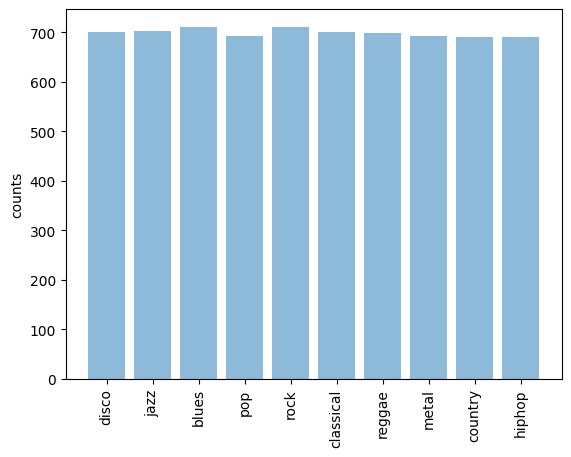

In [82]:
# Checking if train_data is balanced

plt.rcdefaults()

objects = class_names
y_pos = np.arange(len(train_data_counts))
performance = train_data_counts

plt.bar(y_pos, train_data_counts, align='center', alpha=0.5)
plt.xticks(y_pos, objects,rotation=90)
plt.ylabel('counts')

plt.show()

In [83]:
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

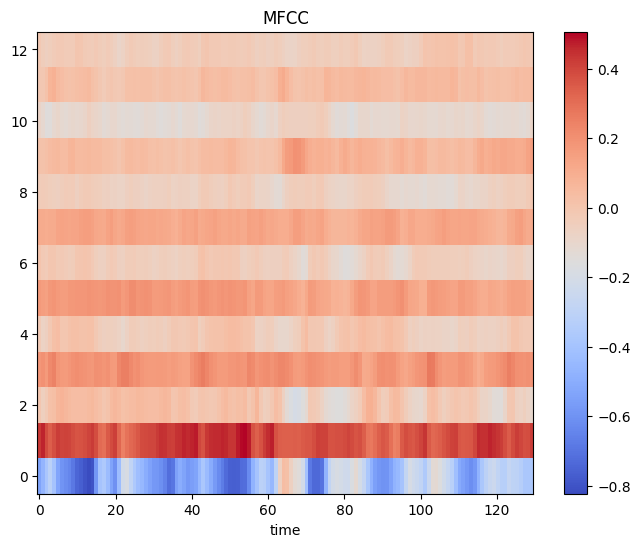

In [153]:
# plotting one sample

image_number = random.randint(0,x_train.shape[0])
fig, ax = plt.subplots( figsize=(8, 6))
m_slaney = x_train[image_number].T.reshape((13,130))
img = ax.imshow(m_slaney, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
ax.set(title='MFCC')
ax.set_xlabel('time')
# ax.set_ylabel('Y-axis')

fig.colorbar(img);

## Model

In [43]:
model_input = Input(shape=(130,13,1))
x = model_input

x = Conv2D(64,kernel_size=3,strides=2,padding="same",activation=None)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.25)(x)

x = Conv2D(64,kernel_size=3,strides=2,padding="same",activation=None)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.25)(x)

x = Conv2D(112,kernel_size=3,strides=2,padding="same",activation=None)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.25)(x)

x = Conv2D(112,kernel_size=3,strides=2,padding="same",activation=None)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.25)(x)

x = Conv2D(112,kernel_size=3,strides=2,padding="same",activation=None)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.25)(x)

x = Conv2D(112,kernel_size=3,strides=2,padding="same",activation=None)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.25)(x)

x = Conv2D(256,kernel_size=3,strides=2,padding="same",activation=None)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.25)(x)

x = Conv2D(256,kernel_size=3,strides=2,padding="same",activation=None)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.25)(x)

x = Conv2D(256,kernel_size=3,strides=2,padding="same",activation=None)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.25)(x)

x = Conv2D(256,kernel_size=3,strides=2,padding="same",activation=None)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(10,activation=None)(x)
model_output = Activation("softmax")(x)

model = Model(model_input,model_output,name="genre_classifier")
model.compile(loss="categorical_crossentropy",optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])

In [44]:
model.summary()

Model: "genre_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 130, 13, 1)]      0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 65, 7, 64)         640       
_________________________________________________________________
batch_normalization_9 (Batch (None, 65, 7, 64)         256       
_________________________________________________________________
activation_6 (Activation)    (None, 65, 7, 64)         0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 65, 7, 64)         0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 33, 4, 64)         36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 33, 4, 64)    

# Training

In [45]:
hist = model.fit(x_train,y_train_onehot,batch_size=32,validation_data=(x_test,y_test_onehot),epochs=500)

Epoch 1/500
219/219 [==============================] - 2s 10ms/step - loss: 2.4372 - accuracy: 0.1545 - val_loss: 2.4259 - val_accuracy: 0.1111
Epoch 2/500
219/219 [==============================] - 2s 9ms/step - loss: 2.2277 - accuracy: 0.1894 - val_loss: 2.7156 - val_accuracy: 0.1111
Epoch 3/500
219/219 [==============================] - 2s 9ms/step - loss: 2.1167 - accuracy: 0.2196 - val_loss: 2.5422 - val_accuracy: 0.1315
Epoch 4/500
219/219 [==============================] - 2s 9ms/step - loss: 2.0082 - accuracy: 0.2664 - val_loss: 2.3114 - val_accuracy: 0.2460
Epoch 5/500
219/219 [==============================] - 2s 9ms/step - loss: 1.9167 - accuracy: 0.2906 - val_loss: 2.1889 - val_accuracy: 0.2730
Epoch 6/500
219/219 [==============================] - 2s 9ms/step - loss: 1.8708 - accuracy: 0.3103 - val_loss: 2.0555 - val_accuracy: 0.2977
Epoch 7/500
219/219 [==============================] - 2s 9ms/step - loss: 1.8050 - accuracy: 0.3322 - val_loss: 2.0278 - val_accuracy: 0.293

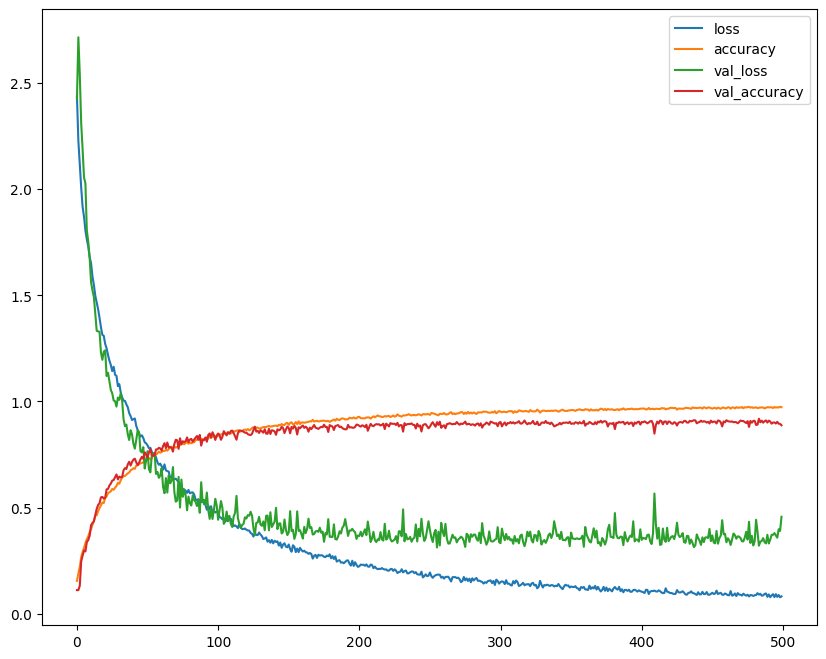

In [146]:
pd.DataFrame(hist.history).plot(figsize=(10,8))

# Evaluation

In [138]:
model.evaluate(x_test,y_test_onehot)

94/94 [==============================] - 0s 4ms/step - loss: 0.1516 - accuracy: 0.9619


[0.15158316493034363, 0.9619492888450623]

In [139]:
y_proba_train = model.predict(x_train)
y_classes_train = y_proba_train.argmax(axis=1)
accuracy_train = ((y_classes_train == y_train).sum() / len(y_train) ) * 100
print(f"train accuracy : {accuracy_train}")

train accuracy : 96.66666666666667


In [140]:
y_proba_test = model.predict(x_test)
y_classes_test = y_proba_test.argmax(axis=1)
accuracy_test = ((y_classes_test == y_test).sum() / len(y_test) ) * 100
print(f"test accuracy : {accuracy_test}")

test accuracy : 96.19492656875835


In [149]:
print(classification_report(y_test,y_classes_test))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       299
           1       0.94      1.00      0.97       288
           2       0.98      0.98      0.98       289
           3       0.99      0.95      0.97       307
           4       0.91      0.92      0.92       289
           5       1.00      0.99      0.99       299
           6       0.98      0.93      0.95       301
           7       0.97      0.97      0.97       308
           8       0.99      0.92      0.95       308
           9       0.94      0.98      0.96       308

    accuracy                           0.96      2996
   macro avg       0.96      0.96      0.96      2996
weighted avg       0.96      0.96      0.96      2996



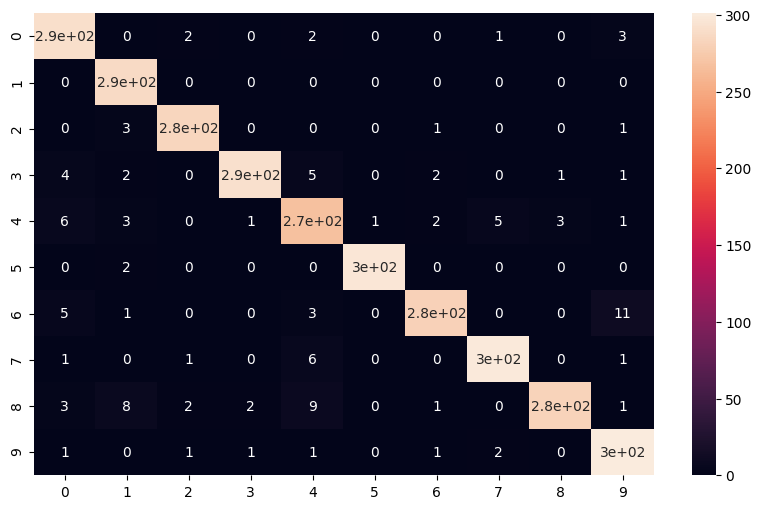

In [150]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test,y_classes_test),annot=True)

In [ ]:
save_model(model,"genre_classification.h5")